In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA, PCA
from sklearn.datasets import make_circles
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from ipywidgets import interactive, interact, fixed, widgets
import time

# POD-Galerkin ROM : equation de la chaleur
## Calcul des modes POD (=PCA) pour l'equation de la chaleur


L'équation de la chaleur en une dimension spatiale est donnée par :
$$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$$
où $\alpha $ représente la diffusivité thermique.

La condition initiale est choisie comme une fonction gaussienne centrée :

$$u(x,0) = A e^{-\frac{x^2}{2\sigma^2}}$$

où $\sigma$ est l'écart-type de la distribution initiale.

La solution théorique de l'équation de la chaleur pour la condition initiale gaussienne est :

$$u(x,t) = \frac{A\sqrt{2\pi \sigma^2}}{\sqrt{2\pi (\sigma^2 + 2\alpha t)}} e^{-\frac{x^2}{2(\sigma^2 + 2\alpha t)}}$$

Simulons cela numériquement :

Solution calculée en 1.232e-01 s


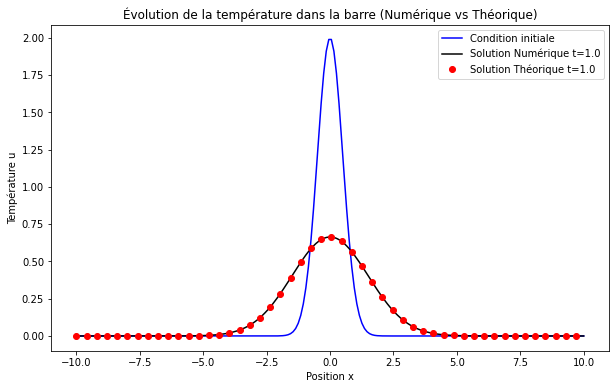

In [2]:
# Paramètres de simulation
L = 20.0        # longueur du domaine
T = 1.0         # temps final
Nx = 200        # nombre de points dans l'espace
Nt = 300       # nombre de points dans le temps
alpha = 1.0   # diffusivité thermique
dx = L / Nx     # pas spatial
dt = T / Nt     # pas temporel

# Création des grilles spatiale et temporelle
x = np.linspace(-L/2, L/2, Nx)
t = np.linspace(0, T, Nt)

# Condition initiale (Gaussienne centrée)
sigma = 0.5
A = 2.0 # amplitude
u0 = A * np.exp(-x**2 / (2 * sigma**2)) 

# Solution à chaque pas de temps
u_sol = [u0.copy()]

start = time.time()
for n in range(1, Nt):
    u_new = np.zeros_like(u0)
    for i in range(1, Nx - 1):
        u_new[i] = u_sol[n-1][i] + alpha * dt / dx**2 * (u_sol[n-1][i+1] - 2*u_sol[n-1][i] + u_sol[n-1][i-1])
    u_sol.append(u_new)
end = time.time()
print("Solution calculée en %.3e s"%(end-start))

# Calcul de la solution théorique pour l'instant final
i = - 1 # indice de l'instant à afficher (en plus de l'instant initial)
u_theorique =  np.exp(-x**2 / (2 * (sigma**2 + 2 * alpha * t[i]))) * A * np.sqrt((2 * np.pi * sigma**2))  / np.sqrt(2 * np.pi * (sigma**2 + 2 * alpha * t[i]))

# Affichage des résultats
plt.figure(figsize=(10, 6))
plt.plot(x, u0, 'b-', label='Condition initiale')
plt.plot(x, u_sol[i], 'k-', label=f'Solution Numérique t={t[i]:.1f}')
plt.plot(x[::4], u_theorique[::4], 'ro', label=f'Solution Théorique t={t[i]:.1f}', )
plt.title('Évolution de la température dans la barre (Numérique vs Théorique)')
plt.xlabel('Position x')
plt.ylabel('Température u')
plt.legend()
plt.show()

On calcul maintenant les modes POD

(300, 200)
(200, 200)


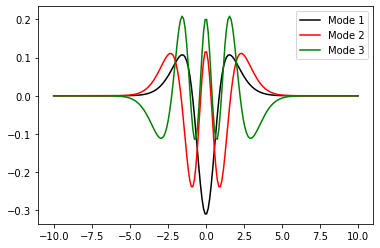

In [3]:
data_chaleur = np.array(u_sol)
print(data_chaleur.shape)

# Calcul de la matrice de covariance (penser à centrer les données
mean = np.mean(data_chaleur, axis=0)
data_centered = data_chaleur - mean
cov_matrix = np.dot(data_centered.T, data_centered) / data_chaleur.shape[0]
print(cov_matrix.shape)

# Calcul des valeurs propres et vecteurs propres
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Tri des vecteurs propres par valeurs propres décroissantes 
# (en pratique, pour des cas plus gros, on calculera habituellement uniquement les n plus grandes vp avec des algos dédiés, par ex. arnoldi)
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvectors = eigenvectors[:, sorted_indices]
sorted_eigenvalues = eigenvalues[sorted_indices]

# Affichage des trois premiers modes POD
plt.figure()
plt.plot(x, sorted_eigenvectors[:, 0], 'k', label='Mode 1')
plt.plot(x, sorted_eigenvectors[:, 1], 'r', label='Mode 2')
plt.plot(x, sorted_eigenvectors[:, 2], 'g', label='Mode 3')
plt.legend()
plt.show()


On écrit le modèle réduit par projection sur les 3 premiers modes POD

In [6]:
# Matrice reduite POD
n_modes = 3
up = sorted_eigenvectors[:, :n_modes]

# derivée deeconde spatiale des modes
dxx_up = np.gradient(np.gradient(up, dx, edge_order=2, axis=0), dx, edge_order=2, axis=0)

# derivée seconde de la moyenne 
dxx_mean = np.gradient(np.gradient(mean, dx, edge_order=2), dx, edge_order=2)

# calcul du vecteur l :
l = up.T.dot(dxx_mean)

# calcul de la matrice L :
L = up.T.dot(dxx_up)


#projection de la CI sur la base réduite pour connaitre les conditions initiales sur les a_i
a0 = up.T.dot(u0-mean)


# intégration temporelle 
Nt_ROM = Nt 
alpha = 2.0
a_sol = [a0.copy()]
start = time.time()
for n in range(1, Nt_ROM):
    a = a_sol[n-1] + dt * alpha * (l + L.dot(a_sol[n-1]))
    a_sol.append(a)
end = time.time()
print("Solution calculée en %.3e s"%(end-start))


# Fonction pour visualiser les resultats
def plot_solution(n):
    u_visu = a_sol[n].dot(up.T) + mean
    u_theorique =  np.exp(-x**2 / (2 * (sigma**2 + 2 * alpha * dt * n))) * A * np.sqrt((2 * np.pi * sigma**2))  / np.sqrt(2 * np.pi * (sigma**2 + 2 * alpha * dt * n))
    plt.plot(x, u_visu, label='ROM')
    plt.plot(x[::4], u_theorique[::4], 'r.', label='théorique')
    plt.xlabel("x")
    plt.ylabel("u")
    plt.ylim([-0.1,2.5])
    plt.title("t = %.1f"%(dt*n))
    
    plt.legend()
    plt.show()

# Création d'un widget interactif pour jouer avec gamma et le nombre de composantes
w = widgets.IntSlider(value=0, min=0, max=Nt_ROM-1)
interactive_plot = interactive(plot_solution, n=w)
interactive_plot



Solution calculée en 1.199e-03 s


interactive(children=(IntSlider(value=0, description='n', max=299), Output()), _dom_classes=('widget-interact'…

## Reaction-Diffusion

In [7]:
# Paramètres de simulation
L = 50.        # longueur du domaine
T = 7.        # temps final
Nx = 100        # nombre de points dans l'espace
Nt = 100       # nombre de points dans le temps
alpha = 1.0   # diffusivité thermique
s = 1.0   # intensité nl
dx = L / Nx     # pas spatial
dt = T / Nt     # pas temporel

# Création des grilles spatiale et temporelle
x = np.linspace(-L, L, Nx)
t = np.linspace(0, T, Nt)

# Condition initiale 
sigma = L / 10.
u0_rd = 0.1 * np.exp(-x**2 / (2 * sigma**2)) 

# Solution à chaque pas de temps
u_sol_rd = [u0_rd.copy()]

start = time.time()
for n in range(1, Nt):
    u_new = np.zeros_like(u0_rd)
    # conditions limites instationnaires:
    #u_new[0] = 1 / (1+np.exp(+5*t[n]))**2
    #u_new[Nx - 1] = 1 / (1+np.exp(1-5*t[n]))**2
    for i in range(1, Nx - 1):
        u_new[i] = u_sol_rd[n-1][i] + alpha * dt / dx**2 * (u_sol_rd[n-1][i+1] - 2*u_sol_rd[n-1][i] + u_sol_rd[n-1][i-1]) + s * dt * u_sol_rd[n-1][i] * (1 - u_sol_rd[n-1][i])
    u_sol_rd.append(u_new)
end = time.time()
print("Solution calculée en %.3e s"%(end-start))



# Fonction pour visualiser les resultats
def plot_solution(n):
    plt.plot(x, u_sol_rd[n])
    plt.xlabel("x")
    plt.ylabel("u")
    plt.ylim([-0.1,1.2])
    plt.title("t = %.1f"%t[n])
    plt.show()

# Création d'un widget interactif pour jouer avec gamma et le nombre de composantes
w = widgets.IntSlider(value=0, min=0, max=Nt-1)
interactive_plot = interactive(plot_solution, n=w)
interactive_plot

Solution calculée en 2.827e-02 s


interactive(children=(IntSlider(value=0, description='n', max=99), Output()), _dom_classes=('widget-interact',…

(100, 100)
(100, 100)


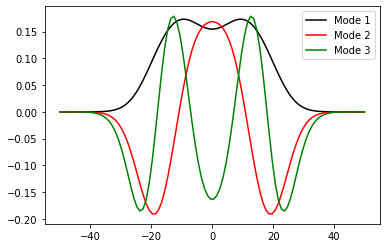

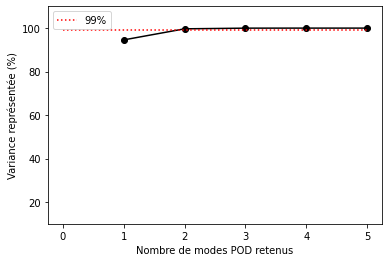

In [8]:
data_rd = np.array(u_sol_rd)
print(data_rd.shape)

# Calcul de la matrice de covariance (penser à centrer les données
mean = np.mean(data_rd, axis=0)
data_centered = data_rd - mean
cov_matrix = np.dot(data_centered.T, data_centered) / data_rd.shape[0]
print(cov_matrix.shape)

# Calcul des valeurs propres et vecteurs propres
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Tri des vecteurs propres par valeurs propres décroissantes 
# (en pratique, pour des cas plus gros, on calculera habituellement uniquement les n plus grandes vp avec des algos dédiés, par ex. arnoldi)
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvectors = eigenvectors[:, sorted_indices]
sorted_eigenvalues = eigenvalues[sorted_indices]

# Affichage des trois premiers modes POD
plt.figure()
plt.plot(x, sorted_eigenvectors[:, 0], 'k', label='Mode 1')
plt.plot(x, sorted_eigenvectors[:, 1], 'r', label='Mode 2')
plt.plot(x, sorted_eigenvectors[:, 2], 'g', label='Mode 3')
plt.legend()
plt.show()

plt.figure()
n_mode = 5
plt.plot(range(1,n_mode+1), np.cumsum(sorted_eigenvalues[:n_mode])/np.sum(sorted_eigenvalues)*100, 'k-o')
plt.plot([99]*(n_mode+1), 'r:', label="99%") # ligne des 95%
plt.xlabel("Nombre de modes POD retenus")
plt.ylabel("Variance représentée (%)")
plt.ylim([10,110])
plt.legend()
plt.show()

In [11]:
# Matrice reduite POD
n_modes = 10
up = sorted_eigenvectors[:, :n_modes]

# derivée deeconde spatiale des modes
dxx_up = np.gradient(np.gradient(up, dx, edge_order=2, axis=0), dx, edge_order=2, axis=0)

# derivée seconde de la moyenne 
dxx_mean = np.gradient(np.gradient(mean, dx, edge_order=2), dx, edge_order=2)

# calcul des vecteur l :
l = up.T.dot(dxx_mean) 
p = up.T.dot(mean * (1 - mean))

# calcul des matrice L :
L = up.T.dot(dxx_up)
P =  -2 * up.T.dot(up * np.array([mean] * n_modes).T)

# calcul du tenseur Q:
Q = np.zeros((n_modes,n_modes,n_modes))
for i in range(n_modes):
    for j in range(n_modes):
        for k in range(n_modes):
            Q[i,j,k] = up[:,i].dot(up[:,j] * up[:,k])

#projection de la CI sur la base réduite pour connaitre les conditions initiales sur les a_i
a0 = up.T.dot(u0_rd-mean)


a_sol = [a0.copy()]
start = time.time()
Nt_ROM = Nt *2
for n in range(1, Nt_ROM):
    a = a_sol[n-1] + dt * (alpha * (l + L.dot(a_sol[n-1])) +  s * (p + P.dot(a_sol[n-1]) + a_sol[n-1]- Q.dot(a_sol[n-1]).dot(a_sol[n-1])))
    a_sol.append(a)
end = time.time()
print("Solution calculée en %.3e s"%(end-start))


# Fonction pour visualiser les resultats
def plot_solution(n):
    u_visu = a_sol[n].dot(up.T) + mean
    plt.plot(x, u_visu, label='ROM')
    try:
        plt.plot(x[::4], u_sol_rd[n][::4], 'r.', label='FOM')
    except:
        pass
    
    plt.xlabel("x")
    plt.ylabel("u")
    plt.ylim([-0.1,1.2])
    plt.title("t = %.1f"%(dt*n))
    plt.legend()
    plt.show()

# Création d'un widget interactif pour jouer avec gamma et le nombre de composantes
w = widgets.IntSlider(value=0, min=0, max=Nt_ROM-1)
interactive_plot = interactive(plot_solution, n=w)
interactive_plot

Solution calculée en 3.187e-03 s


interactive(children=(IntSlider(value=0, description='n', max=199), Output()), _dom_classes=('widget-interact'…

## DEIM : choix des points

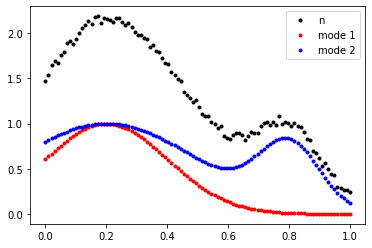

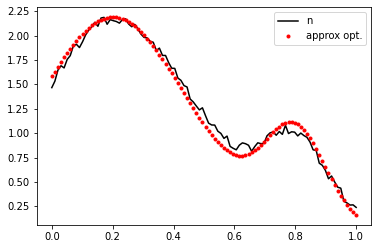

In [13]:
x = np.linspace(0, 1, 100)

sigma = 0.2
center = 0.2
q_1 = np.exp(-(x-center)**2 / (2 * sigma**2)) 

sigma = 0.1
center = 0.8
q_2 = 0.7 * np.exp(-(x-center)**2 / (2 * sigma**2))  

sigma = 0.3
center = 0.2
q_2 +=  np.exp(-(x-center)**2 / (2 * sigma**2))  

sigma = 0.3
center = 0.5
q_3 = np.exp(-(x-center)**2 / (2 * sigma**2)) 

# On crée un vecteur à partir d'un mélange de 3 gaussiennes
n = q_1 + q_2 + 0.2 * q_3 + 0.1 * np.random.rand(100)

# on cherche une approximation à partir de deux modes q_1 et q_2 (non orthogonal pour cet exemple)
Q = np.array([q_1, q_2]).T
b_optimal = np.linalg.pinv(Q).dot(n)
n_2_opt = Q.dot(b_optimal)

# visualisation
plt.figure()
plt.plot(x, n, 'k.', label="n")
plt.plot(x, q_1, 'r.', label="mode 1")
plt.plot(x, q_2, 'b.', label="mode 2")
plt.legend()
plt.show()


plt.figure()
plt.plot(x,n, 'k', label="n")
plt.plot(x,n_2_opt, 'r.', label="approx opt.")
plt.legend()
plt.show()


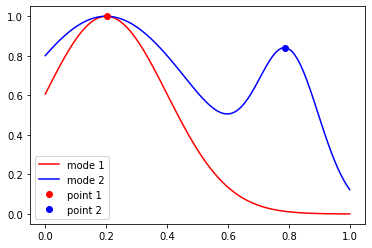

In [9]:
# le process DEIM illustré :
# premier point : on choisit l'indice où q_1 est maximum
ind1 = np.argmax(q_1)

# deuxième point : on choisit le point où l'erreur est la plus grande quand on cherche à approximer q_2 avec q_1 en utilisant le point 1
approx_q2 = q_1 * q_2[ind1] / q_1[ind1]
error_q2 = np.abs(q_2 - approx_q2)
ind2 = np.argmax(error_q2)


# visualization des deux points choisis
plt.figure()
plt.plot(x, q_1, 'r', label="mode 1")
plt.plot(x, q_2, 'b', label="mode 2")
plt.plot(x[ind1], q_1[ind1], 'ro', label="point 1")
plt.plot(x[ind2], q_2[ind2], 'bo', label="point 2")
plt.legend()
plt.show()



Le procédé fournit naturellement les points où les deux modes ont des formes les plus différentes

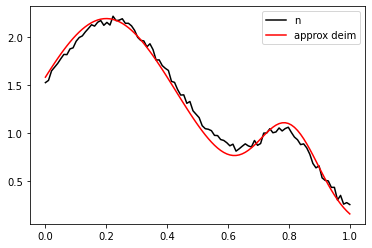

In [10]:
# on utilise ces points pour approximer n en trouvant la combinaison linéaire qui permet de matcher n exactement en ces deux points
mat_deim = np.array([[q_1[ind1],q_2[ind1]],[q_1[ind2],q_2[ind2]]])
rhs_deim = np.array([n[ind1], n[ind2]])
b_deim = np.linalg.inv(mat_deim).dot(rhs_deim)


n_deim = Q.dot(b_deim)

# visualisation
plt.figure()
plt.plot(x,n, 'k', label="n")
plt.plot(x,n_2_opt, 'r', label="approx deim")
plt.legend()
plt.show()

Si on choisit mal les points :

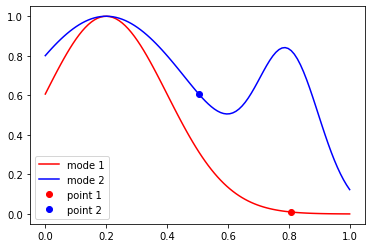

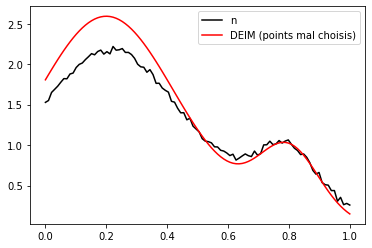

In [11]:
ind1 = 80 # le mode 1 est faible en ce point

# deuxième point : on choisit un point arbitraire
ind2 = 50


# visualization des deux points choisis
plt.figure()
plt.plot(x, q_1, 'r', label="mode 1")
plt.plot(x, q_2, 'b', label="mode 2")
plt.plot(x[ind1], q_1[ind1], 'ro', label="point 1")
plt.plot(x[ind2], q_2[ind2], 'bo', label="point 2")
plt.legend()
plt.show()

# on utilise ces points pour approximer n en trouvant la combinaison linéaire qui permet de matcher n exactement en ces deux points
mat_deim_wrong = np.array([[q_1[ind1],q_2[ind1]],[q_1[ind2],q_2[ind2]]])
rhs_deim_wrong  = np.array([n[ind1], n[ind2]])
b_deim_wrong  = np.linalg.inv(mat_deim_wrong ).dot(rhs_deim_wrong )


n_deim_wrong  = Q.dot(b_deim_wrong )

# visualisation
plt.figure()
plt.plot(x,n, 'k', label="n")
plt.plot(x,n_deim_wrong, 'r', label="DEIM (points mal choisis)")
plt.legend()
plt.show()

## DMD
Cas d'advection-diffusion

In [12]:
# Paramètres de simulation
L = 10.0       # Longueur du domaine
Nx = 100       # Nombre de points spatiaux
x = np.linspace(0, L, Nx)
dx = L / (Nx - 1)
c = 1.0        # Vitesse d'advection
nu = 0.1       # Coefficient de diffusion
dt = 0.01      # Pas de temps
T = 1.5        # Temps final
Nt = int(T / dt)  # Nombre de pas de temps

# Condition initiale
u = np.exp(-((x - L/2)**2) / 0.5)

# Matrice pour stocker la solution
U = np.zeros((Nx, Nt))
U[:, 0] = u

# Solution de l'équation d'advection-diffusion par différences finies
for n in range(1, Nt):
    U[1:-1, n] = U[1:-1, n-1] - c * dt / dx * (U[1:-1, n-1] - U[:-2, n-1]) + \
                 nu * dt / dx**2 * (U[2:, n-1] - 2 * U[1:-1, n-1] + U[:-2, n-1])
    U[0, n] = U[-1, n] = 0  # Conditions aux limites

# DMD à la main
X = U[:, :-1]
X_prime = U[:, 1:]

# SVD sur X
U_svd, Sigma, Vt = np.linalg.svd(X, full_matrices=False)
V = Vt.T # attention np.linalg.svd retoure V^T et pas V

# Réduction de rang pour la SVD
r = 20  # Nombre de modes à conserver
U_r = U_svd[:, :r]
Sigma_r = np.diag(Sigma[:r])
V_r = V[:, :r]

# Calcul de K_tilde
K_tilde = U_r.T @ X_prime @ V_r @ np.linalg.inv(Sigma_r)

# Valeurs propres et vecteurs propres de A_tilde
eigvals, Q = np.linalg.eig(K_tilde)

# Modes DMD
Phi = X_prime @ V_r @ np.linalg.inv(Sigma_r) @ Q

# Calcul des amplitudes b des modes DMD pour correspondre à la condition initiale
b = np.linalg.pinv(Phi) @ U[:, 0]

# Dynamique temporelle DMD
Nt_ROM = Nt * 2
t_dynamics = np.zeros((r, Nt_ROM), dtype=complex)

# Calculer la dynamique temporelle pour chaque mode
for t in range(2*Nt):
    t_dynamics[:, t] = b * (eigvals**t)

# Reconstruction des données
DMD_reconstructed = Phi @ t_dynamics


# Fonction pour visualiser les resultats
def plot_solution(n):
    plt.plot(x, DMD_reconstructed.real[:,n], label='DMD')
    try:
        plt.plot(x[::4], U[::4,n], 'r.', label='FOM')
    except:
        pass
    
    plt.xlabel("x")
    plt.ylabel("u")
    plt.ylim([-0.1,1.2])
    plt.title("t = %.1f"%(dt*n))
    plt.legend()
    plt.show()

# Création d'un widget interactif pour jouer avec gamma et le nombre de composantes
w = widgets.IntSlider(value=0, min=0, max=Nt_ROM-1)
interactive_plot = interactive(plot_solution, n=w)
interactive_plot




interactive(children=(IntSlider(value=0, description='n', max=299), Output()), _dom_classes=('widget-interact'…

# Bonus

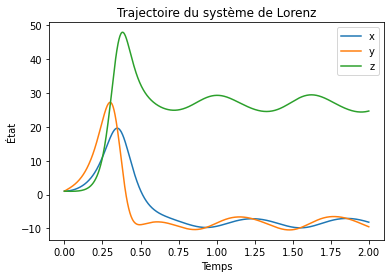

In [9]:
def lorenz_system(t, state, sigma, rho, beta):
    x, y, z = state
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

# Paramètres du système de Lorenz
sigma, rho, beta = 10, 28, 8/3

# Conditions initiales et configuration de l'intégration
initial_state = [1.0, 1.0, 1.0]
t_span = (0, 2)  # Intégrer de t=0 à t=2
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Points de temps où la solution est évaluée

# Résolution du système de Lorenz
sol = solve_ivp(lorenz_system, t_span, initial_state, args=(sigma, rho, beta), t_eval=t_eval, method='RK45')

# Visualisation des résultats
plt.plot(sol.t, sol.y[0], label='x')
plt.plot(sol.t, sol.y[1], label='y')
plt.plot(sol.t, sol.y[2], label='z')
plt.legend()
plt.title('Trajectoire du système de Lorenz')
plt.xlabel('Temps')
plt.ylabel('État')
plt.show()


In [53]:
def create_features(data):
    """ Crée des termes non-linéaires (polynomiaux) pour la régression. """
    x, y, z = data
    return np.vstack([x, y, z, x*y, y*z, x*z, x*x, y*y]).T

# Création des caractéristiques et dérivées
X = create_features(sol.y)

# Calcul des dérivées numériques simples
X_dot = np.gradient(sol.y.T, axis=0, edge_order=2) / np.gradient(sol.t, edge_order=2)[:, None]
X_dot_smooth = np.gradient(X, axis=0, edge_order=2) / np.gradient(t_eval, edge_order=2)[:, None]


# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Then apply Lasso
models = [Lasso(alpha=0.01, max_iter=200000, fit_intercept=True, tol=1e-7).fit(X, X_dot[:, i]) for i in range(X_dot.shape[1])]

# Affichage des coefficients pour chaque variable
for i, model in enumerate(models):
    print(f"Équation pour la variable {i+1}:")
    print(" + ".join(f"{coef:.2f}*{name}" for coef, name in zip(model.coef_, ['x', 'y', 'z', 'xy', 'yz', 'xz', 'x^2', 'y^2', 'z^2']) if abs(coef) > 1e-1))

Équation pour la variable 1:
-9.78*x + 9.88*y
Équation pour la variable 2:
27.94*x + -0.72*y + -0.99*xz
Équation pour la variable 3:
-2.69*z + 0.99*xy
